# Execution notebook
This notebook serves as a walk-through of the code to execute training of the ViT keypoint tracker

In [ ]:
from utils.train_test_split import test_train_split
from utils.data_utils import FaceLandmarksDataset

In [ ]:
#Prepare paths

root = "/Users/annastuckert/Documents/GitHub/ViT_facemap/ViT-pytorch"


## Data Preprocessing

### Test-train split (incl. dropping NAs)

In [ ]:
# Define paths
csv_path = f"{root}/data/facemap/CollectedData_AVS.csv"
dest_folder = f"{root}/data/facemap/data_No_NaN"
source_folder = f"{root}/data/facemap"


# Call the function to process data
test_train_split(csv_path, source_folder, dest_folder)

## Data augmentation

Arguments:

rotation = how much rotation (degrees) should be applied to the image
img_height = input image height (consider changing this to automatically be derived from meta data files if expecting it not to be uniform)
img_size = size in pixels (ViT expect 224)

## Define transformations to be applied, and input parameters to the arguments

In [ ]:
#from utils.Dataaugmentation import Rotate, ZeroPadHeight, Rescale, HorizontalFlip, GaussianBlur
from torchvision import transforms, utils
import importlib
from utils.Dataaugmentation import Rotate, ZeroPadHeight, Rescale, HorizontalFlip, GaussianBlur

#from utils import Dataaugmentation
#importlib.reload(Dataaugmentation)

# Set the parameters for image augmentation
rotation = 10  # Degrees to rotate image
img_width = 846  # Width of the input image to pad the height to match
final_im_size = 224  # Final image size (224x224 pixels)

# Define transformations using transforms.Compose
rotate_rescale = transforms.Compose([
    Rotate(rotation),
    ZeroPadHeight(img_width),
    Rescale(final_im_size)
])

flip_rescale = transforms.Compose([
    HorizontalFlip(),
    ZeroPadHeight(img_width),
    Rescale(final_im_size)
])

pad_rescale = transforms.Compose([
    ZeroPadHeight(img_width),  # Use img_width instead of hardcoded value
    Rescale(final_im_size),
])

rotate_flip_rescale = transforms.Compose([
    HorizontalFlip(),
    Rotate(rotation),
    ZeroPadHeight(img_width),
    Rescale(final_im_size)
])

blur = transforms.Compose([
    GaussianBlur(),
    ZeroPadHeight(img_width),
    Rescale(final_im_size)
])

In [ ]:
#from utils.Dataaugmentation import Rotate, ZeroPadHeight, Rescale, HorizontalFlip, GaussianBlur
from torchvision import transforms, utils
import importlib
from utils.Dataaugmentation import Rotate, ZeroPadHeight, Rescale, HorizontalFlip, GaussianBlur

#from utils import Dataaugmentation
#importlib.reload(Dataaugmentation)

# Set the parameters for image augmentation
rotation = 10  # Degrees to rotate image
img_width = 846  # Width of the input image to pad the height to match
final_im_size = 224  # Final image size (224x224 pixels)

# Define transformations using transforms.Compose
rotate_rescale = transforms.Compose([
    Rotate(rotation),
    ZeroPadHeight(img_width),
    Rescale(final_im_size)
])

flip_rescale = transforms.Compose([
    HorizontalFlip(),
    ZeroPadHeight(img_width),
    Rescale(final_im_size)
])

pad_rescale = transforms.Compose([
    ZeroPadHeight(img_width),  # Use img_width instead of hardcoded value
    Rescale(final_im_size),
])

rotate_flip_rescale = transforms.Compose([
    HorizontalFlip(),
    Rotate(rotation),
    ZeroPadHeight(img_width),
    Rescale(final_im_size)
])

blur = transforms.Compose([
    GaussianBlur(),
    ZeroPadHeight(img_width),
    Rescale(final_im_size)
])

In [ ]:


# Define a dictionary to associate names with each transformation
transforms_dict = {
    'rotate_rescale': rotate_rescale,
    'flip_rescale': flip_rescale,
    'pad_rescale': pad_rescale,
    'rotate_flip_rescale': rotate_flip_rescale,
    'blur': blur
}

# Import the AugmentedFaceDataset class
from utils.Dataaugmentation import AugmentedFaceDataset

# Define the paths
root = "/Users/annastuckert/Documents/GitHub/ViT_facemap/ViT-pytorch"
csv_file = f"{root}/data/facemap/data_No_NaN/train/train_data.csv"
source_folder = f"{root}/data/facemap/data_No_NaN/train/"
output_dir = f"{root}/data/facemap/data_No_NaN/train/augmented_data"

# Initialize the dataset with defined transformations
face_dataset = AugmentedFaceDataset(csv_file=csv_file, root_dir=source_folder, output_dir=output_dir)

# Apply the transformations and save
face_dataset.apply_transforms_and_save(transforms_dict)


# Running Training

In order to train the ViT, the following sections are run. Subprocess is used in order to run train.py from within a python script.

For reference, the following arguments are to be specified for the training model.

"--name", default="test" 
--> "Name of this run. Used for monitoring."

"--dataset", default="facemap" 
--> "Which downstream task and dataset to use"

"--model_type", choices=["ViT-B_16", "ViT-B_32", "ViT-L_16", "ViT-L_32", "ViT-H_14", "R50-ViT-B_16"], default="ViT-B_16"
-->help="Which variant to use."

"--pretrained_dir", type=str, default="ViT-B_16.npz"
--> "Where to search for pretrained ViT models. If not modified, will search in the directory where .ipynb project execution file is placed."

"--output_dir", default="output", type=str
-->"The output directory where checkpoints will be written."

"--img_size", default=224, type=int
--> ="Resolution size for image"

"--train_batch_size", default=20, type=int
--> "Batch size for training."

"--eval_batch_size", default=20, type=int
h--> "Total batch size for eval."

"--eval_every", default=100, type=int,
--> "Run prediction on validation set every so many steps. Will always run one evaluation at the end of training."

"--learning_rate", default=2e-4, type=float,
--> "The initial learning rate for the optimizer."

"--weight_decay", default=1e-2, type=float,
--> "Weight deay if we apply some."

"--num_steps", default=3000, type=int,
--> "Total number of training epochs to perform."

"--decay_type", choices=["cosine", "linear"], default="linear", #changed from cosine as I believe this is what Yichen did
--> "How to decay the learning rate."

"--warmup_steps", default=500, type=int,
--> "Step of training to perform learning rate warmup for."

"--max_grad_norm", default=1.0, type=float,
--> "Max gradient norm."

"--local_rank", type=int, default=-1,
--> "local_rank for distributed training on gpus" - I think this might be if you have more than one GPU available, you can distribute training. Or if one GPU has more than one core

'--seed', type=int, default=42,
--> "random seed for initialization"

'--gradient_accumulation_steps', type=int, default=1, # tried adjusting this from 1 to 25 to match Yichen
--> "Number of updates steps to accumulate before performing a backward/update pass."

('--fp16', action='store_true',
--> "Whether to use 16-bit float precision instead of 32-bit")

'--fp16_opt_level', type=str, default='O2',
-->"For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
                             "See details at https://nvidia.github.io/apex/amp.html")

'--loss_scale', type=float, default=0,
-->"Loss scaling to improve fp16 numeric stability. Only used when fp16 set to True. 0 (default value): dynamic loss scaling. Positive power of 2: static loss scaling value.


In [ ]:
import subprocess

# Define the command to run the script with arguments
command = [
    "python", "train.py",
    "--name", "experiment_20240825",
    "--dataset", "facemap",
    "--model_type", "ViT-B_16",
    "--pretrained_dir", "ViT-B_16.npz",
    "--output_dir", "model_checkpoints",  # Added missing comma here
    "--train_batch_size", str(20),
    "--eval_batch_size", str(20),
    "--eval_every", str(5), 
    "--num_steps", str(5),
]

# Run the script
result = subprocess.run(command, capture_output=True, text=True)

# Print the output and errors (if any)
print("Output:", result.stdout)
print("Errors:", result.stderr)


In [ ]:
import subprocess

# Define the command to run the script with arguments
command = [
    "python", "train_epochs.py",
    "--name", "experiment_20240825",
    "--dataset", "facemap",
    "--model_type", "ViT-B_16",
    "--pretrained_dir", "ViT-B_16.npz",
    "--output_dir", "model_checkpoints",
    "--train_batch_size", str(20),
    "--eval_batch_size", str(20),
    "--eval_every", str(2),
    "--num_epochs", str(2),  # Changed from --num_steps to --num_epochs
]

# Run the script
result = subprocess.run(command, capture_output=True, text=True)

# Print the output and errors (if any)
print("Output:", result.stdout)
print("Errors:", result.stderr)


# Video inference

In [ ]:
# Create 10 second video for testing purpose

import cv2

def create_one_second_video(input_video_path, output_video_path):
    # Open the input video file
    cap = cv2.VideoCapture(input_video_path)
    
    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return
    
    # Get the video's frames per second (fps) and size information
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Calculate the number of frames for 10 seconds
    frames_to_extract = int(fps)*10
    
    # Define the codec and create a VideoWriter object to save the output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    # Read and write frames to the output file
    frame_count = 0
    while cap.isOpened() and frame_count < frames_to_extract:
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)
        frame_count += 1
    
    # Release resources
    cap.release()
    out.release()
    print(f"10-second video saved to {output_video_path}")

# Example usage
input_video_path = '/Users/annastuckert/Documents/GitHub/ViT_facemap/ViT-pytorch/Facemap_videos/cam1_G7c1_1.avi'
video_path = '/Users/annastuckert/Documents/GitHub/ViT_facemap/ViT-pytorch/Facemap_videos/cam1_G7c1_1_10seconds.avi'
create_one_second_video(input_video_path, video_path)

In [18]:
# Import necessary functions and libraries
import torch
from utils.video_inference import load_model, run_inference_on_video, overlay_keypoints_on_video_and_save_csv

# Define paths and configuration
video_path = '/Users/annastuckert/Documents/GitHub/ViT_facemap/ViT-pytorch/Facemap_videos/cam1_G7c1_1_10seconds.avi'  # Path to your input video
#checkpoint_path = '/Users/annastuckert/Documents/GitHub/ViT_facemap/ViT-pytorch/model_checkpoints/test_checkpoint.pth'  # Path to your model checkpoint file
checkpoint_path = "/Users/annastuckert/Documents/GitHub/ViT_facemap/ViT-pytorch/output/test_checkpoint.pth"
output_video_path = 'output/keypoints.mp4'  # Path to save the output video
output_csv_path = 'output/keypoints.csv'  # Path to save the keypoints CSV file
config_name = 'ViT-B_16'  # Use the appropriate configuration name for your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Select device

# Load the model
model = load_model(checkpoint_path, config_name, device)

# Run inference on the video to get predicted keypoints
keypoints_list = run_inference_on_video(video_path, model, device)

# Overlay the predicted keypoints on the video frames and save the output
overlay_keypoints_on_video_and_save_csv(video_path, keypoints_list, output_video_path, output_csv_path)

# Output paths and check files
print(f"Output video saved to: {output_video_path}")
print(f"Output CSV saved to: {output_csv_path}")


Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])


KeyboardInterrupt: 

# Check model inference predictions against test_set labels and predictions

In [22]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchvision import transforms

# Define the transform (assuming this is required elsewhere)
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Uncomment if resizing is needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

#imageName = 'img6725_rotate_rescale_augmented.jpg'
imageName = 'img8819_flip_rescale_augmented.jpg'
im = Image.open("augmented_data_test/" + imageName)
x = transform(im)
x.size()

labels = pd.read_csv('augmented_data_test/augmented_labels.csv')
labelsKepoints = labels.loc[labels['image_name'] == imageName].values.flatten().tolist()[1:]

preds = pd.read_csv('predictions.csv')
predsKeypoints = preds.loc[labels['image_name'] == imageName].values.flatten().tolist()[1:-1]



In [27]:
#Loading KP predictions form model forward pass
# Transform the image (assuming you have a transform function defined)
x = transform(im)

# Get model output
# Assuming the model is already defined and loaded
out = model(x.unsqueeze(0))

# Convert the model output to a format suitable for plotting
keypoints = out[0].detach().cpu().numpy()  # Detach and move to CPU if using a GPU

# Access the first row of keypoints since shape is (1, 24)
keypoints = keypoints[0]

print(keypoints)


Input tensor size: torch.Size([1, 197, 768])
[121.94194   60.218903 131.15402   72.31736  125.944405  94.50775
 118.42703   90.16376  165.85487   73.311264 171.8595    88.13829
 170.39938  108.54636  151.40823  109.71796  149.58807   95.67305
 152.45528  124.20621  157.7619   159.62982  154.4991   170.48734 ]


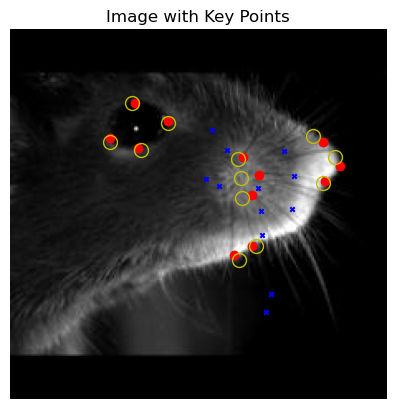

In [24]:
plt.imshow(im)
# Loop through the keypoints and plot them
for i in range(0, len(keypoints), 2):
    x_coord = keypoints[i]
    y_coord = keypoints[i + 1]
    plt.scatter(x_coord, y_coord, s=10, c='blue', marker='x')  # Plot each keypoint
for i in range(0, 23, 2):
    plt.plot(labelsKepoints[i], labelsKepoints[i+1], 'ro')
    plt.plot(predsKeypoints[i], predsKeypoints[i+1], 'yo', markerfacecolor='none', markersize=10) #allows us to plot x+y coordinate of each key point (i+1) and loops over the 24 keypoints, skipping every second step since we plot both x+y 
 
plt.title("Image with Key Points")
plt.axis('off')  # Turn off axis labels
plt.show()
 

# Visualize loss curve



In [ ]:
# Using train.py producing lossCurve in steps
d_lossCurve = pd.read_csv('lossCurve.csv')

colors = {'training_loss': 'blue', 'validation_loss': 'orange'}  # Define colors for different metrics
metric_labels = {'training_loss': 'Training Loss', 'validation_loss': 'Test Loss'}  # Rename metrics
labels2 = {'validation_loss':'Test loss', 'training_loss':'Training loss'}
for metric, color in colors.items():
    indices = [i for i, m in enumerate(d_lossCurve['metric']) if m == metric]
    #print(f"Metric: {metric}, Indices: {indices}")  # Debug print statement
    if indices:
        #steps = [d_lossCurve['steps'][i] for i in indices]
        steps = [i*2 for i, _ in enumerate(indices)]
        loss = [d_lossCurve['training_loss'][i] for i in indices]
        if metric == 'training_loss':
            stepsPerEpoch = 49
            steps = np.arange(61)

            loss = [np.mean(loss[i*stepsPerEpoch:(i+1)*stepsPerEpoch]) for i in steps]
            
        #print(f"Steps: {steps}, Loss: {loss}")  # Debug print statement
        plt.plot(steps, loss, label=f'{labels2[metric]}', color=color)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Set the y-axis to scientific notation
plt.yscale('log')

plt.show()

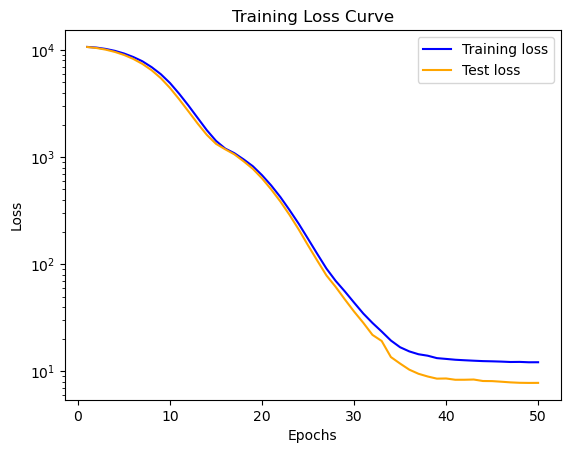

In [25]:
# Using train_epochs.py, producing lossCurve in epochs
import pandas as pd
import matplotlib.pyplot as plt

d_lossCurve = pd.read_csv('lossCurve.csv')

colors = {'training_loss': 'blue', 'validation_loss': 'orange'}  # Define colors for different metrics
metric_labels = {'training_loss': 'Training Loss', 'validation_loss': 'Test Loss'}  # Rename metrics
labels2 = {'validation_loss':'Test loss', 'training_loss':'Training loss'}
for metric, color in colors.items():
    indices = [i for i, m in enumerate(d_lossCurve['metric']) if m == metric]
    #print(f"Metric: {metric}, Indices: {indices}")  # Debug print statement
    if indices:
        steps = [d_lossCurve['epoch'][i] for i in indices]
        #steps = [i*2 for i, _ in enumerate(indices)]
        loss = [d_lossCurve['training_loss'][i] for i in indices]
        # if metric == 'training_loss':
        #     stepsPerEpoch = 49
        #     steps = np.arange(61)

        #     loss = [np.mean(loss[i*stepsPerEpoch:(i+1)*stepsPerEpoch]) for i in steps]
            
        #print(f"Steps: {steps}, Loss: {loss}")  # Debug print statement
        plt.plot(steps, loss, label=f'{labels2[metric]}', color=color)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Set the y-axis to scientific notation
plt.yscale('log')

plt.show()

# Evaluation metrics

## PCK

PCK measures the percentage of keypoints that are predicted correctly within a certain normalized distance from the ground truth keypoints.

In [54]:
import numpy as np
import pandas as pd

def calculate_pck(labels, preds, alpha=0.2, reference_points=(4, 5)):
    """
    Calculate PCK (Percentage of Correct Keypoints) for each image and identify incorrect keypoints.

    Args:
        labels (pd.DataFrame): Ground truth keypoints with image names.
        preds (pd.DataFrame): Predicted keypoints with image names.
        alpha (float): Threshold for PCK, typically 0.2.
        reference_points (tuple): Indices of keypoints to use as reference for normalization.

    Returns:
        pck_results (dict): Dictionary of image_name to (PCK value, list of incorrect keypoints).
    """
    pck_results = {}
    num_keypoints = (labels.shape[1] - 1) // 2  # Assuming first column is 'image_name'

    for _, row in labels.iterrows():
        image_name = row['image_name']
        label_keypoints = row.values[1:].reshape(num_keypoints, 2)  # Ground truth keypoints
        print(label_keypoints)
        
        pred_row = preds.loc[preds['image_names'] == image_name]
        if pred_row.empty:
            print(f"No predictions found for image {image_name}")
            continue
        pred_keypoints = pred_row.values[0][1:-1].reshape(num_keypoints, 2)  # Predicted keypoints
        print(pred_keypoints)

        # Calculate reference distance (e.g., shoulder distance)
        ref_distance = np.linalg.norm(label_keypoints[reference_points[0]] - label_keypoints[reference_points[1]])
        threshold_distance = alpha * ref_distance

        correct_keypoints = 0
        incorrect_keypoints = []  # To track which keypoints are incorrect

        for j in range(num_keypoints):
            distance = np.linalg.norm(pred_keypoints[j] - label_keypoints[j])
            if distance < threshold_distance:
                correct_keypoints += 1
            else:
                incorrect_keypoints.append(j)  # Store the index of the incorrect keypoint

        pck = correct_keypoints / num_keypoints
        pck_results[image_name] = (pck, incorrect_keypoints)  # Store PCK and incorrect keypoints

    return pck_results

# Load the data
labels = pd.read_csv('augmented_data_test/augmented_labels.csv')
preds = pd.read_csv('predictions.csv')

# Calculate PCK - automatically use the distance between eye_top and eye_bottom (which I expect to be quite stable) as reference pair (1,3).
# KP should be within 10% of the distance between the ref pair
pck_results = calculate_pck(labels, preds, alpha=0.1, reference_points=(1, 3))

# Print results
for image_name, (pck_value, incorrect_keypoints) in pck_results.items():
    print(f"Image: {image_name}, PCK: {pck_value:.2f}, Incorrect Keypoints: {incorrect_keypoints}")




[[127.8795600825896 33.303879631694365]
 [112.674580701465 53.512062794620434]
 [133.88540019338353 62.51508496319241]
 [148.82483521538333 50.778408994566405]
 [28.054821663277476 94.0453167450583]
 [25.480686711594142 113.40934372486052]
 [35.66746162889935 118.48246392211618]
 [84.91326320072774 100.07951634891262]
 [76.66792532717245 88.85395100661357]
 [93.56097772299364 112.41431640316952]
 [90.82155423186146 139.3757846299775]
 [99.8689386628226 143.60882239391995]]
[[128.33844 33.343956]
 [112.17247 51.524803]
 [133.50066 60.945]
 [148.71765 50.000748]
 [31.962414 89.83034]
 [24.738914 106.17035]
 [36.8041 118.15755]
 [81.747574 98.35839]
 [79.93626 87.1143]
 [85.37697 109.52513]
 [88.063065 139.12582]
 [100.3542 142.83914]]
[[74.13194083494956 42.812873202013826]
 [95.30841192338178 56.58447399279879]
 [78.44566642703755 72.3234463251248]
 [60.40645031466931 66.42133170050258]
 [188.64174746128728 65.6343830838861]
 [197.6613555174717 82.94725264944454]
 [189.81821807731131 91